# Projecting JunoCam images
Raw *JunoCam* images consist of several framelets, each corresponding to a different filter. As the spacecraft moves, the framelets correspond to different parts of the sky. To project the raw image to a map, we need to calculate the positions of each pixel in the image. 

Also be sure to compile the C script in the `projection/` folder. To do this, open the `projection/` folder in a terminal, and run `make`. 

Once those are done, import the projector functions. The first command points to the location of the `JunoCamProjection` module. 

In [1]:
import sys
sys.path.append('../')
from projection import projector
from projection.camera_funcs import CameraModel
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import skimage.color
import tqdm
import spiceypy as spice
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


The projection functions make use of the [SPICE toolkit](https://naif.jpl.nasa.gov/naif/toolkit.html) which read in kernel files that are produced by NAIF. These kernel files define the position of planets and spacecraft and are updated periodically. 

To project *JunoCam* data, we will need the Juno kernels. These will be automatically downloaded from the NAIF website as needed. You will need to point to a location on your machine for where these files should be stored. You can store them in the same directory as your script, but if you expect that you will run this script in different directories, you should point to a central location. This will create a `kernels/` folder and populate it with different kernels that define the *Juno* spacecraft and Jupiter coordinate systems. In the next cell, set `KERNEL_DATAFOLDER` to point to the `kernels` folder that was created. 

**WARNING: The downloaded data is on the order of several GBs for multiple PJs. Make sure you have the disk space for it**

In [2]:
KERNEL_DATAFOLDER = './kernels'

Now initialize the `Projector` class with the location of our image and metadata that's associated with it. *JunoCam* images can be downloaded from [the JunoCam Processing website](https://www.missionjuno.swri.edu/junocam/processing). To process the raw images, be sure to select the JUNOCAM filter so as to filter out user generated images. 

Click on the image, and download the images and metadata zips to this folder. Unzip them to produce the`ImageSet/` and `DataSet/` folders. Note the name of metadata file inside the `Dataset/` folder. 

We initialize the Projector class by inputting the folder containing the images (`ImageSet/`), the metadata file (`DataSet/xxxx-Metadata.json`) and the location of the kernels. This example shows the included GRS image from Perijove 27 (ID: 8724). The code automatically determines the best value for the jitter in the image start time by fitting the limb of the planet (see timing note [here](https://naif.jpl.nasa.gov/pub/naif/JUNO/kernels/ik/juno_junocam_v03.ti)). 

In [3]:
proj = projector.Projector("ImageSet/", "DataSet/8724-Metadata.json", KERNEL_DATAFOLDER)

Finding jitter: 100%|█████████████████████████████████████████████████████████████████| 240/240 [00:33<00:00,  7.24it/s]


Found best jitter value of -23.0 ms


Once the object is initialized, we can project it. Call the `process` method, which can run in parallel with the `num_procs` argument. This call calculates the lat/lon of the center of each pixel in the original JunoCam framelet, correcting for barrel distortions (see Optical Distortions section [here](https://naif.jpl.nasa.gov/pub/naif/JUNO/kernels/ik/juno_junocam_v03.ti)) and for interframe delay. This will project the image onto a HEALPix whose resolution can be controlled using the `nside` parameter and return the HEALPix 3-channel map array.

Note: This will take a couple minutes. **Be sure to change the number of processors as needed**. 

In [4]:
m = proj.process(nside=1024, num_procs=10)

Projecting self.fname to a HEALPix grid with n_side=1024


Projecting framelets:  97%|███████████████████████████████████████████████████████████▍ | 76/78 [01:50<00:02,  1.45s/it]


Fitting neighbors
Finding neighbors for new image
Calculating image values at new locations


Building image: 100%|████████████████████████████████████████████████████| 1918977/1918977 [00:00<00:00, 2067405.89it/s]


Under the hood, the algorithm first projects the data onto a frame at the mid-point of Juno's trajectory for this image first before building the HEALPix map. The code will also generate a `proj.framedata` object which will contain information from individual framelets in the initial (moving) coordinate system. These correspond to the following data:
* `proj.framedata.coords`: The pixel coordinates in the mid-point frame
* `proj.framedata.image` and `proj.framedata.rawimg`: The flux (and Lommel-Seeliger correction) corrected and raw, decompanded image pixel values
* `proj.framedata.lat` and `proj.framedata.lon`: The latitude/longitude (SIII planetographic) of each pixel
* `proj.framedata.emission` and `proj.framedata.incidence`: The emission and incidence angles for each pixel (radians)
* `proj.framedata.fluxcal`: An initial calibration to remove viewing geometry effects

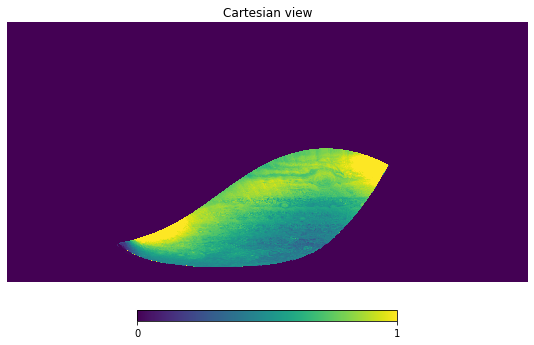

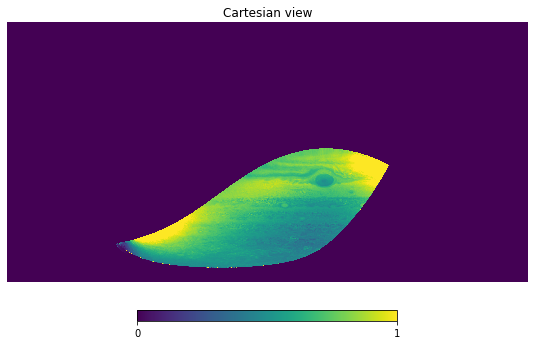

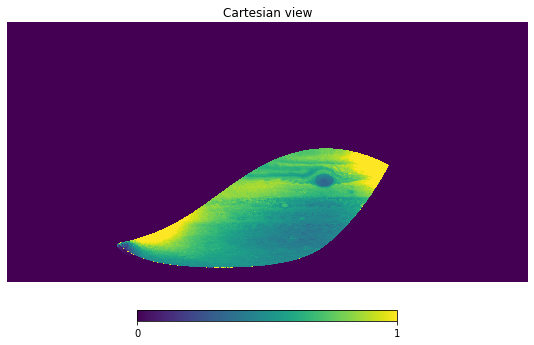

In [5]:
# project onto a cylindrical projection (change this to any HEALPix supported projections)
r_map = hp.cartview(np.clip(m[:,0]/np.percentile(m[:,0], 99), 0, 1), return_projected_map=True, xsize=3600)
g_map = hp.cartview(np.clip(m[:,1]/np.percentile(m[:,1], 99), 0, 1), return_projected_map=True, xsize=3600)
b_map = hp.cartview(np.clip(m[:,2]/np.percentile(m[:,2], 99), 0, 1), return_projected_map=True, xsize=3600)

In [6]:
# create an rgb image from this map
rgb = np.stack([r_map, g_map, b_map], axis=2)

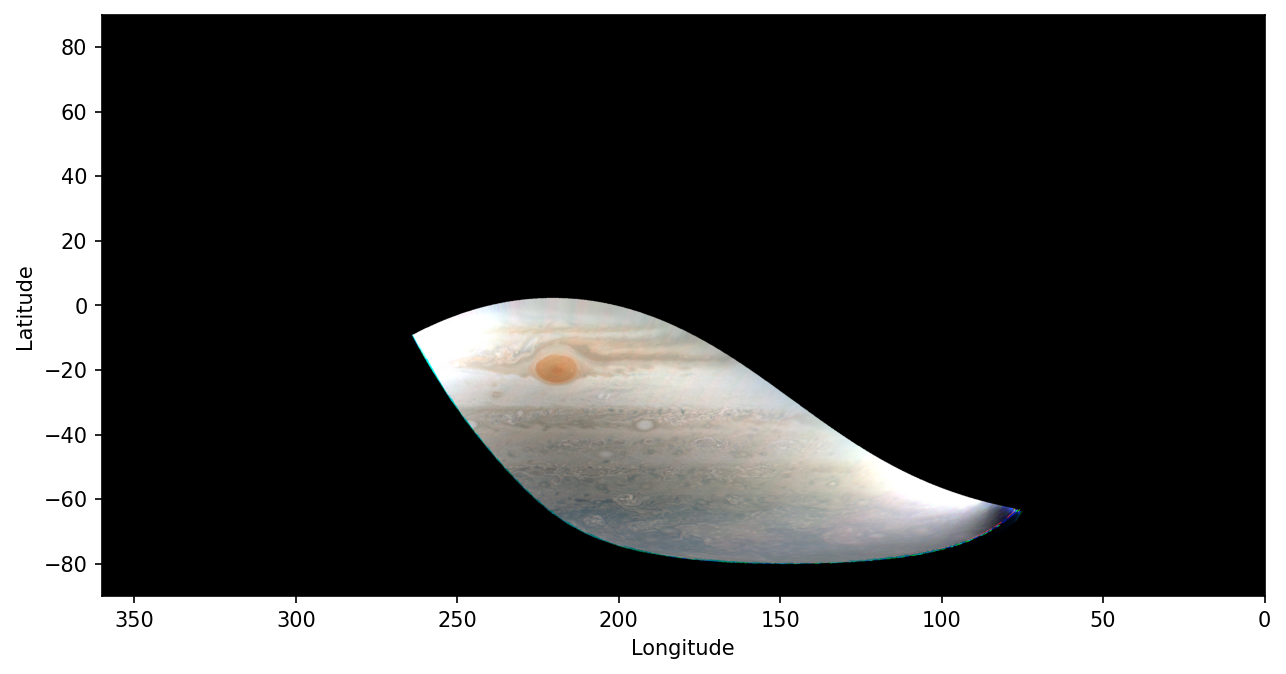

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=150)
ax.imshow(rgb, extent=(0, 360, -90, 90), origin='lower')
ax.set_xlim((360, 0))
ax.set_xlabel(r'Longitude')
ax.set_ylabel(r'Latitude')
plt.show()

We can also see what the mid-point frame looks like by projecting directly onto the pixel coordinates returned by the projection

In [8]:
coords_new = np.transpose(proj.framedata.coords, (1, 0, 2, 3, 4)).reshape(3, -1, 2)
imgvals_new = np.transpose(proj.framedata.image, (1, 0, 2, 3)).reshape(3, -1)

# get the image extents in pixel coordinate space
x0 = np.nanmin(coords_new[:, :, 0])
x1 = np.nanmax(coords_new[:, :, 0])
y0 = np.nanmin(coords_new[:, :, 1])
y1 = np.nanmax(coords_new[:, :, 1])

# create the new frame which spans from the minimum to the maximum in (x, y)
x = np.arange(x0, x1, 0.5)
y = np.arange(y0, y1, 0.5)
X, Y = np.meshgrid(x, y)

# stack these coordinates together and create an indexer to loop through them
pix = np.column_stack([X.flatten(), Y.flatten()])
inds = np.asarray(range(len(pix)))

In [9]:
IMG = projector.create_image_from_grid(coords_new, imgvals_new, pix, inds, X.shape, n_neighbor=2)

Fitting neighbors
Finding neighbors for new image
Calculating image values at new locations


Building image: 100%|███████████████████████████████████████████████████| 11014562/11014562 [00:19<00:00, 552584.10it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


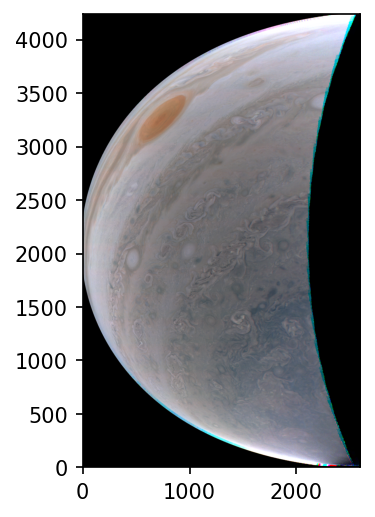

In [10]:
plt.figure(dpi=150)
plt.imshow(IMG / np.percentile(IMG, 99), origin='lower')
plt.show()